### Introduction to Spatial Models

The previous section was mostly on spatial data manipulation, so how do we "model" spatial data?

As an example, let's go harvest some scallops!

##### Data
On Canvas, you should see `scallop.csv` that we'll be using below.
Credit goes to [Matt Wand for this dataset](http://matt-wand.utsacademics.info/webspr/scallop.html)

##### Library
`fields` is a popular R spatial statistics library. 

`conda install -r conda-forge r-fields`

In [9]:
library(fields)
scallop <- read.csv("data/scallop.csv")

In [14]:
head(scallop)

,latitude,longitude,tot.catch
,<dbl>,<dbl>,<int>
1,40.55000,-71.55000,0
2,40.46667,-71.51667,0
3,40.51667,-71.71667,0
4,40.38333,-71.85000,1
5,40.31667,-71.78333,0
6,40.26667,-71.88333,0


In [23]:
class(scallop)

[1] "data.frame"

In [15]:
library(RColorBrewer)
percs <- c(0, 0.5, 0.75, 0.9, 0.95, 0.975, 1)
breaks <- quantile(scallop$tot.catch, percs)
cols <- brewer.pal(length(percs) - 1, "YlOrRd")

In [16]:
breaks

0%     50%     75%     90%     95%   97.5%    100% 
   0.00   30.00  115.25  538.10 1139.50 2581.25 7084.00

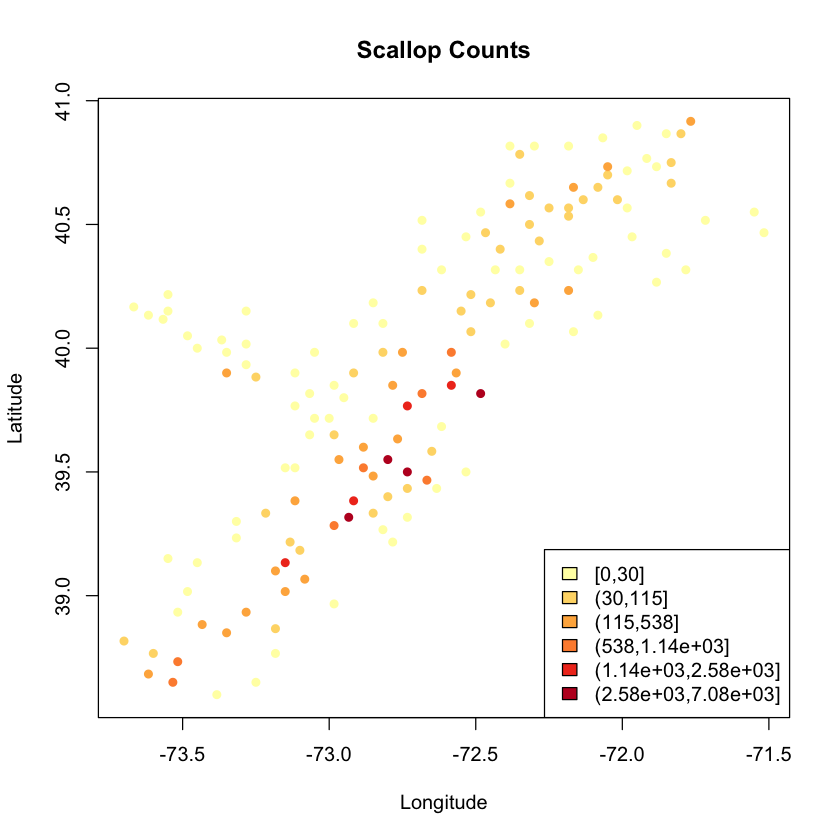

In [17]:
col_cat <- cut(scallop$tot.catch,
               breaks = breaks,
               include.lowest = TRUE)
plot(scallop$longitude, scallop$latitude, col=cols[col_cat], pch=16,
     xlab="Longitude", ylab="Latitude", main="Scallop Counts")
legend("bottomright", legend=levels(col_cat), fill=cols)

In [18]:
table(col_cat) # color category

col_cat
             [0,30]            (30,115]           (115,538]      (538,1.14e+03] 
                 75                  36                  22                   7 
(1.14e+03,2.58e+03] (2.58e+03,7.08e+03] 
                  4                   4 

### Tackle the problem using our usual tools

#### Plot the distribution of the scallop catches

In [19]:
range(scallop$latitude)

[1] 38.60000 40.91667

In [20]:
range(scallop$longitude)

[1] -73.70000 -71.51667

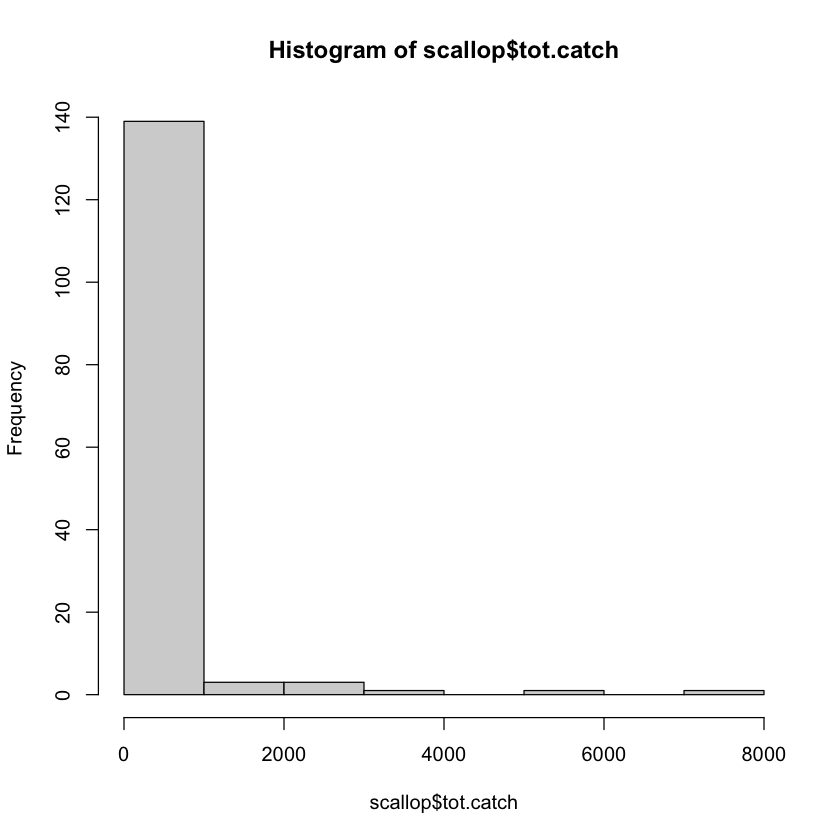

In [24]:
hist(scallop$tot.catch)

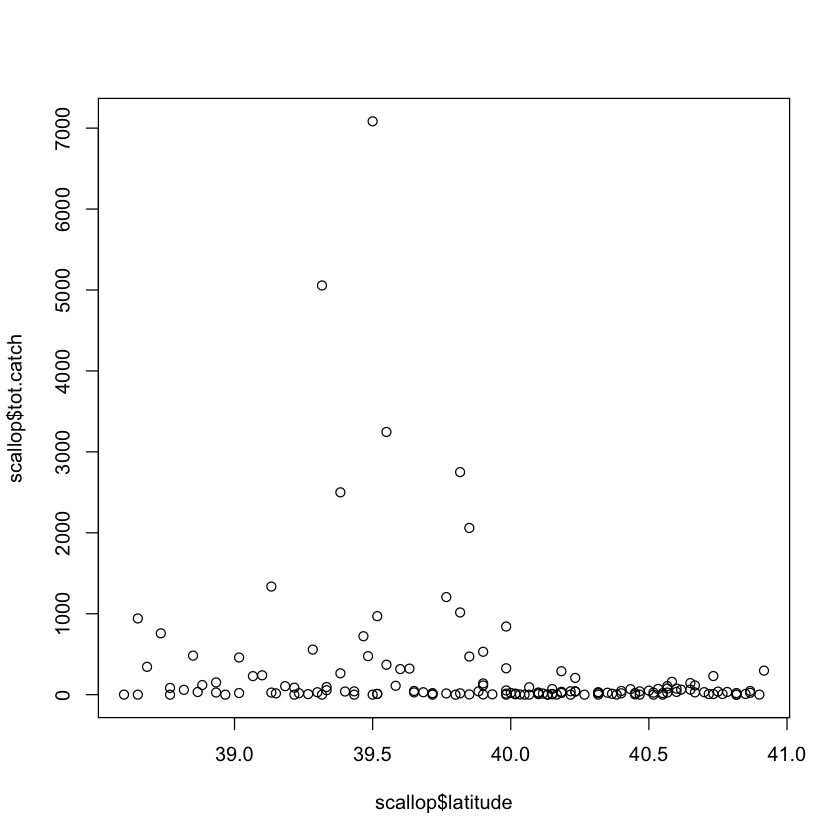

In [22]:
plot(scallop$latitude, scallop$tot.catch)

#### Transform the data such that it looks more "Normal"
- Why do we do this?
- Don't forget to write a function that reverses the transformation

In [25]:
logy <- log(scallop$tot.catch + 1)

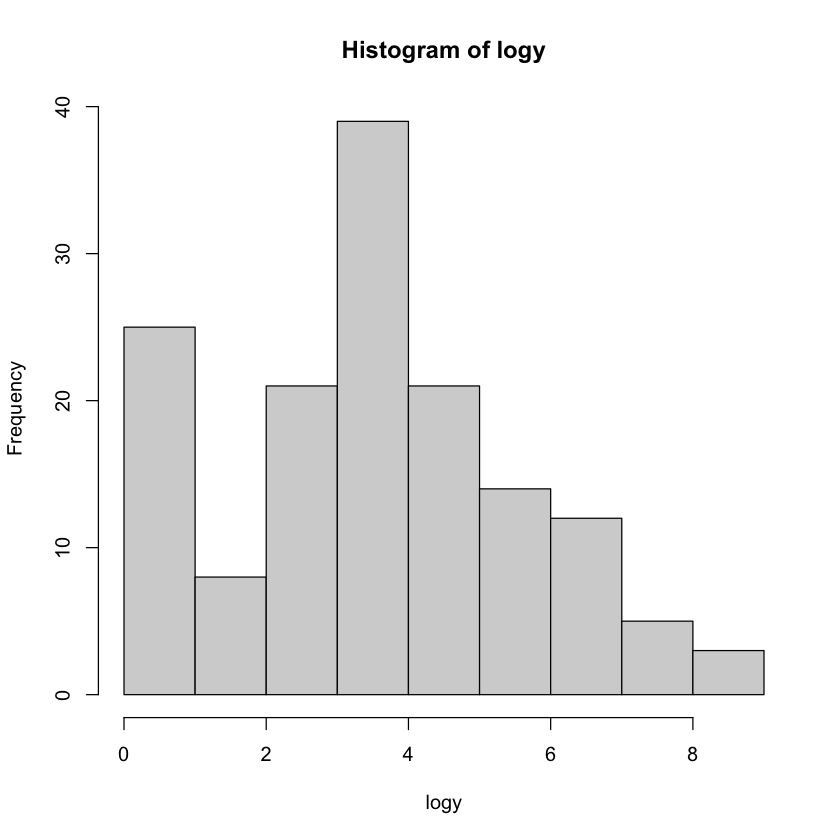

In [26]:
hist(logy)

## Predicting the next best location

#### How could you use OLS to predict the next best location?

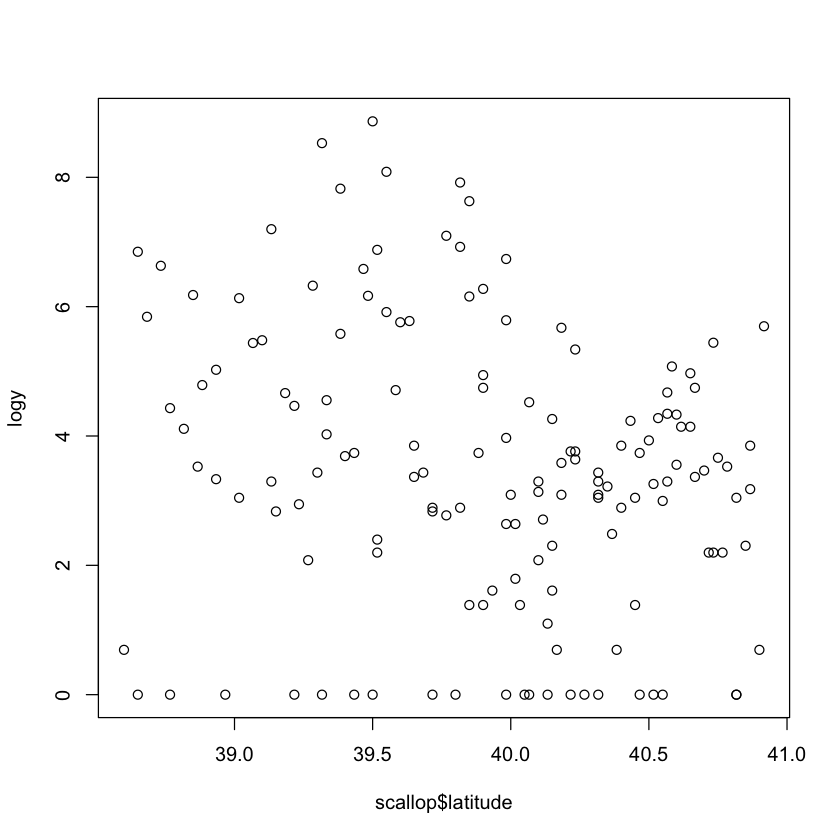

In [27]:
plot(scallop$latitude, logy)

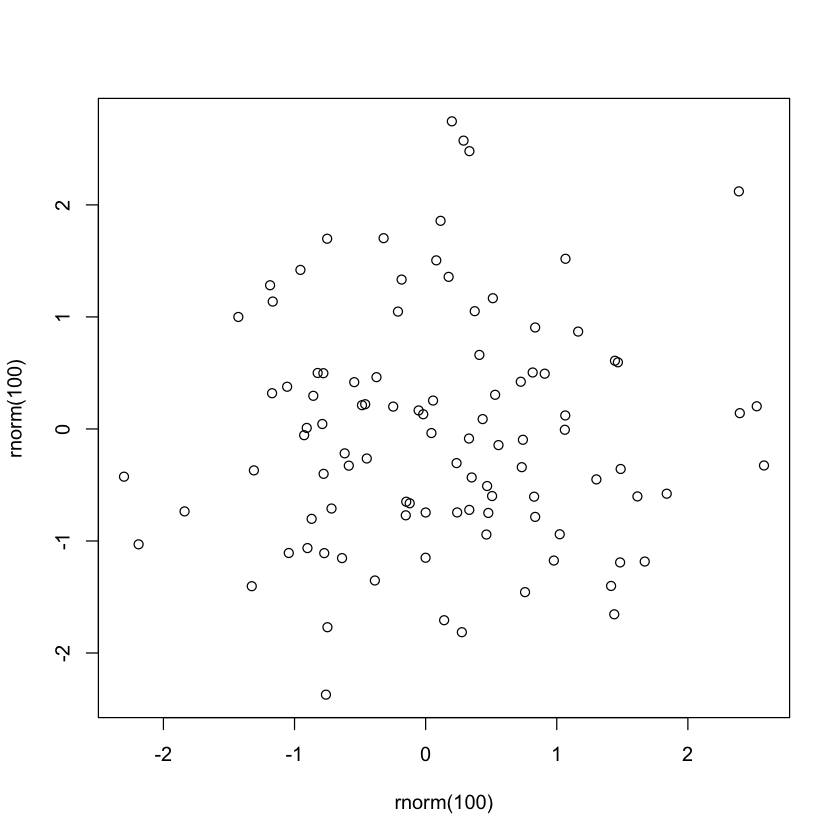

In [31]:
n <- nrow(scallop)
plot(rnorm(100), rnorm(100))

In [7]:
# Small help: this code will provide a grid across the map
longs <- seq(min(scallop$longitude), max(scallop$longitude), length.out=100)
lats <- seq(min(scallop$latitude), max(scallop$latitude), length.out=100)
locs <- expand.grid(longs, lats)

In [54]:
head(locs)

,Var1,Var2
,<dbl>,<dbl>
1,-73.70000,38.6
2,-73.67795,38.6
3,-73.65589,38.6
4,-73.63384,38.6
5,-73.61178,38.6
6,-73.58973,38.6


#### Please visualize the predicted values across the entire map

#### Kriging: the OLS of spatial statistics

Intuitively, we want the predicted "surface" to look like the data points and we believe neighboring points will be similar to one another.

To model the neighboring pattern, Kriging states that $$Y(s_1)|Y(s_2) \sim N(m(s_1), Cov(s_1, s_2))$$

- $m(s_1)$ is commonly referred as the "mean" function. For our application, we will assume $m(s)=0$
- $Cov(s_1, s_2)$ is referred as the covariance function. For our application, we will assume $Cov(s_1, s_2) = \sigma^2 \exp(-\frac{d(s_1, s_2)}{\theta})$
- $d(s_1, s_2)$ is the distance between location $s_1$ and $s_2$, we will use the Great Circle distance since we have long/lat values.

#### Kriging can be done with simple matrix algebra

$$E(Y(s_1)|Y(s_2)) = m(s_1) + Cov(s_1, s_2) Cov(s_2, s_2)^{-1} (Y(s_2) - m(s_2))$$

- $Y(s_2) - m(s_2)$ is the error between our expectation and our training data
- $Cov(s_2, s_2)^{-1}$ discounts the correlation between our training data points.
- $Cov(s_1, s_2)$ picks up covariance between the training locations and our locations of interest
- $m(s_1)$ is what we expected at location $s_1$

In [6]:
krig_mod <- fields::Krig(scallop[, c("longitude", "latitude")],
                         y)
krig_preds <- predict(krig_mod, locs)
# This requires you to define inv_y() to transform the prediction back to the unit of "catches"
y_krigs <- inv_y(krig_preds)

ERROR: Error in Krig.check.xY(x, Y, Z, weights, na.rm, verbose = verbose): object 'y' not found


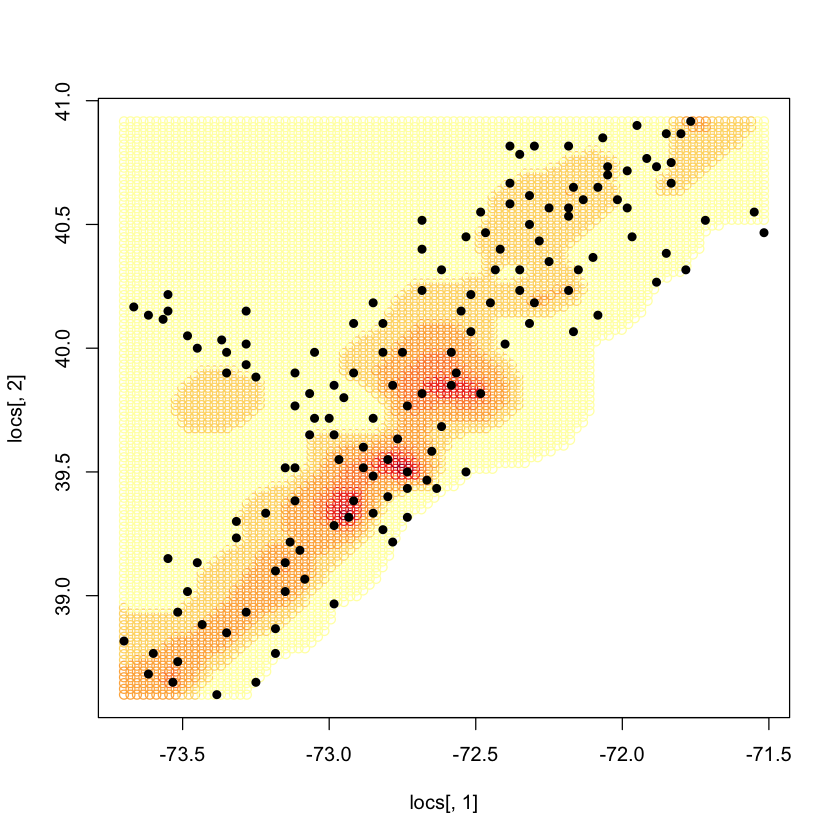

In [58]:
krig_fit_cats <- cut(y_krigs, breaks = breaks, include.lowest = TRUE)
plot(locs[, 1], locs[, 2], col=cols[krig_fit_cats])
points(scallop$longitude, scallop$latitude, pch=16)

In [1]:
?install.packages

#### Advance options in Kriging

#### Question
- Run the code below to make sure it works
- Re-run the code with different paramters, `theta` and `lambda`, what do they do?

In [63]:
# Theta is the "range", all distances will be divided by theta before computing the
# covariance from the distance matrix.
krig_mod2 <- fields::Krig(scallop[, c("longitude", "latitude")],
                          y, cov.args = list(theta=10, Distance='rdist.earth'),
                          lambda=0.5)
krig_preds2 <- predict(krig_mod2, locs)
y_krigs2 <- inv_y(krig_preds2)

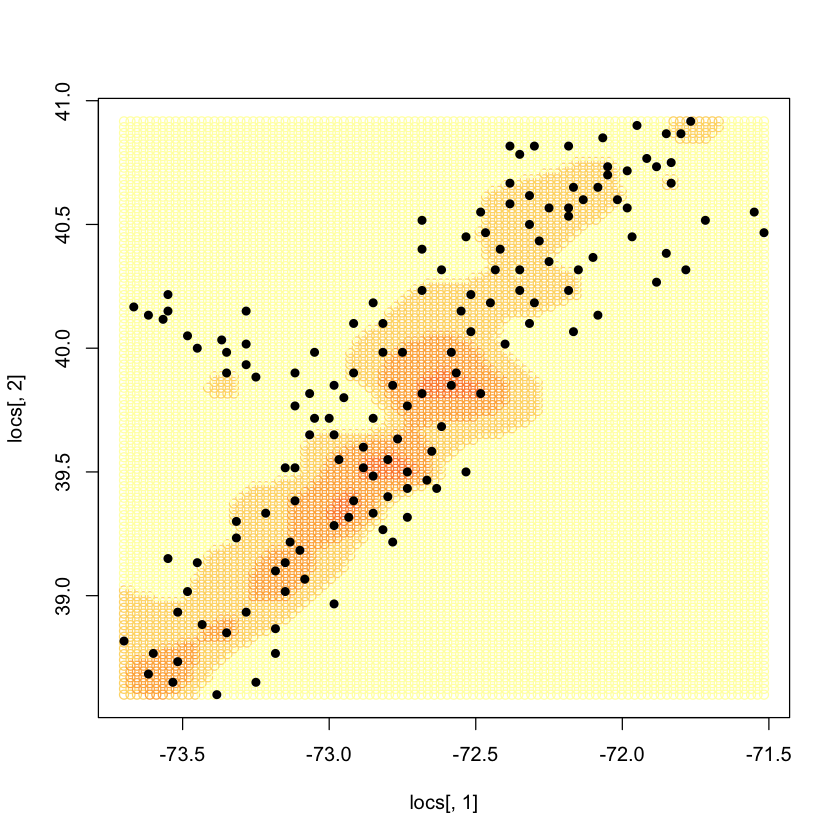

In [64]:
krig_fit_cats2 <- cut(y_krigs2, breaks = breaks, include.lowest = TRUE)
plot(locs[, 1], locs[, 2], col=cols[krig_fit_cats2])
points(scallop$longitude, scallop$latitude, pch=16)

### How is kriging different from a weighted average?

In [66]:
dist_mat <- rdist.earth(locs, scallop[, c("longitude", "latitude")])

In [67]:
dim(dist_mat)

[1] 10000   148

#### What is the weighted average?

In [74]:
y_wa <- rep(NA, nrow(dist_mat))
for(i in seq_len(nrow(dist_mat))){
    y_wa[i] <- weighted.mean(x = y, w=1/dist_mat[i, ]^2)
}

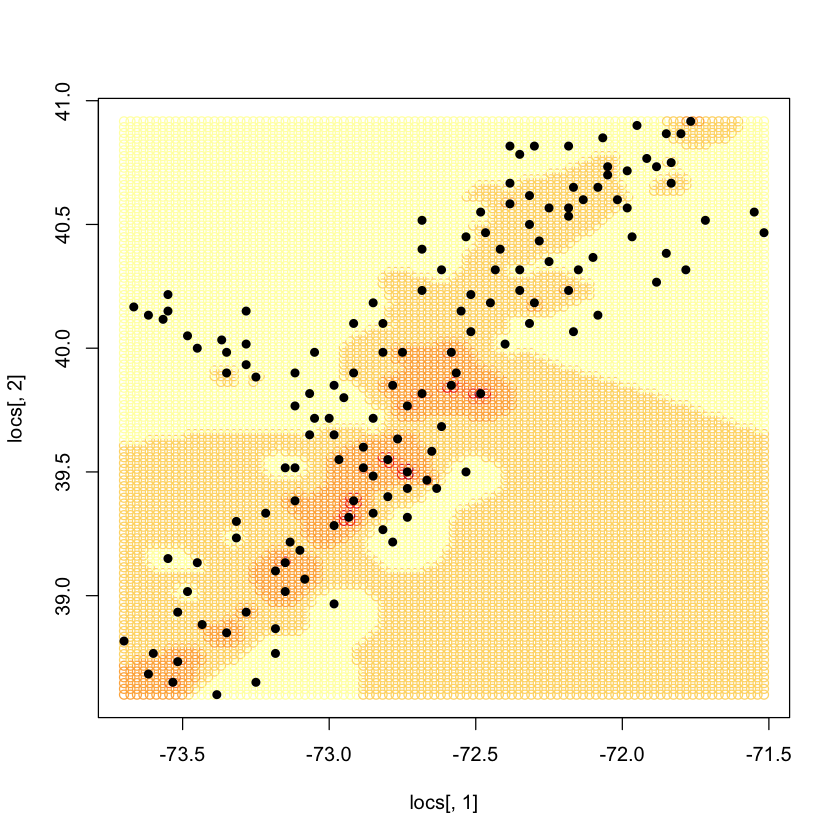

In [75]:
wa_fit_cats <- cut(inv_y(y_wa), breaks = breaks, include.lowest = TRUE)
plot(locs[, 1], locs[, 2], col=cols[wa_fit_cats])
points(scallop$longitude, scallop$latitude, pch=16)

#### How can you explain the bottom right part of the map?

## Cross validation with dependent data

- What is the purpose of cross validation?
- How will this model be used?